In [80]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb

import cv2

import os
from os import listdir
from os.path import isfile, join

import wandb
import gc
from tqdm.notebook import tqdm
import ipywidgets as widgets

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from joblib import dump

In [68]:
VERSION = 'XGBoost_V1'

In [69]:
dataset_types = ['train','valid','test']

images_lists = {}
for dataset_type in dataset_types:
    for cancer_type in ['normal','adenocarcinoma','large_cell_carcinoma','squamous_cell_carcinoma']:
        images_lists[f'{dataset_type}_{cancer_type}_images'] = [f'C:\\Users\\galse\\DS50\\images\\{dataset_type}\\{cancer_type}\\{i}' 
                                                                for i in listdir(f'C:\\Users\\galse\\DS50\\images\\{dataset_type}\\{cancer_type}')]
        print(f"Taille du dataset {dataset_type}_{cancer_type}_images : {len(images_lists[f'{dataset_type}_{cancer_type}_images'])}")

# We can see that the datasets are balanced

Taille du dataset train_normal_images : 148
Taille du dataset train_adenocarcinoma_images : 195
Taille du dataset train_large_cell_carcinoma_images : 115
Taille du dataset train_squamous_cell_carcinoma_images : 155
Taille du dataset valid_normal_images : 13
Taille du dataset valid_adenocarcinoma_images : 23
Taille du dataset valid_large_cell_carcinoma_images : 21
Taille du dataset valid_squamous_cell_carcinoma_images : 15
Taille du dataset test_normal_images : 54
Taille du dataset test_adenocarcinoma_images : 120
Taille du dataset test_large_cell_carcinoma_images : 51
Taille du dataset test_squamous_cell_carcinoma_images : 90


In [70]:
dataframes = {}
for dataset_type in dataset_types:
    dataframes[f'{dataset_type}'] = pd.DataFrame(columns=['image_id','label'])
    dataframes[f'{dataset_type}']['image_id'] = images_lists[f'{dataset_type}_normal_images'] + images_lists[f'{dataset_type}_adenocarcinoma_images'] + images_lists[f'{dataset_type}_large_cell_carcinoma_images'] + images_lists[f'{dataset_type}_squamous_cell_carcinoma_images']
    
    dataframes[f'{dataset_type}']['label'] = np.zeros_like(images_lists[f'{dataset_type}_normal_images'],dtype=int).tolist()+np.ones_like(images_lists[f'{dataset_type}_adenocarcinoma_images'],dtype=int).tolist()+np.full_like(images_lists[f'{dataset_type}_large_cell_carcinoma_images'],2,dtype=int).tolist()+np.full_like(images_lists[f'{dataset_type}_squamous_cell_carcinoma_images'],3,dtype=int).tolist()

In [71]:
dataframes[f'train'].head()

,image_id,label
0,C:\Users\galse\DS50\images\train\normal\10 (2)...,0
1,C:\Users\galse\DS50\images\train\normal\10 (2)...,0
2,C:\Users\galse\DS50\images\train\normal\10 - C...,0
3,C:\Users\galse\DS50\images\train\normal\10 - C...,0
4,C:\Users\galse\DS50\images\train\normal\10 - C...,0


In [72]:
print(len(dataframes['train']),len(dataframes['valid']),len(dataframes['test']))

613 72 315


In [73]:
dataframes[f'valid'].head(15)

,image_id,label
0,C:\Users\galse\DS50\images\valid\normal\003828...,0
1,C:\Users\galse\DS50\images\valid\normal\004007...,0
2,C:\Users\galse\DS50\images\valid\normal\004162...,0
3,C:\Users\galse\DS50\images\valid\normal\4 (2).png,0
4,C:\Users\galse\DS50\images\valid\normal\4 - Co...,0
5,C:\Users\galse\DS50\images\valid\normal\5.png,0
6,C:\Users\galse\DS50\images\valid\normal\6 - Co...,0
7,C:\Users\galse\DS50\images\valid\normal\6 - Co...,0
8,C:\Users\galse\DS50\images\valid\normal\6 - Co...,0
9,C:\Users\galse\DS50\images\valid\normal\7 - Co...,0


In [76]:
image_size = (150, 150)

hog = cv2.HOGDescriptor()
X = {}
for dataset_type in dataset_types:
    X[dataset_type] = []
    for img_path in dataframes[f'{dataset_type}']['image_id'].to_numpy():
        print(img_path)
        img = cv2.imread(img_path)
        print(img)
        img = cv2.resize(img, (100,100))
        #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #feature_vector = hog.compute(img_gray)
        flattened_image = img.reshape(-1)
        X[dataset_type].append(flattened_image)
    X[dataset_type] = np.array(X[dataset_type])
    
y = {}
for dataset_type in dataset_types:
    y[dataset_type] = dataframes[dataset_type]['label'].to_numpy()

C:\Users\galse\DS50\images\train\normal\10 (2) - Copy.png
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
C:\Users\galse\DS50\images\train\normal\10 (2).png
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
C:\Users\galse\DS50\images\train\normal\10 - Copy (2) - Copy.pn

In [77]:
#features = np.array(features).squeeze()
model = xgb.XGBClassifier()
model.fit( X['train'], y['train'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

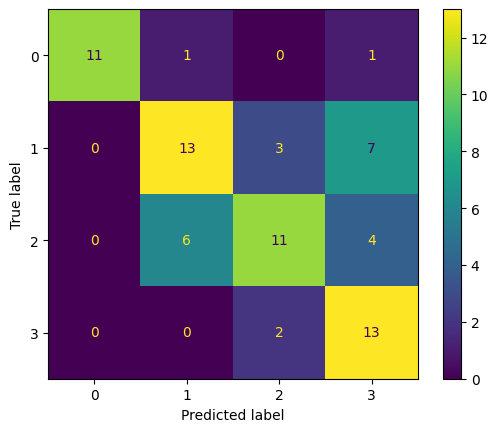

Accuracy on valid dataset :  0.6666666666666666


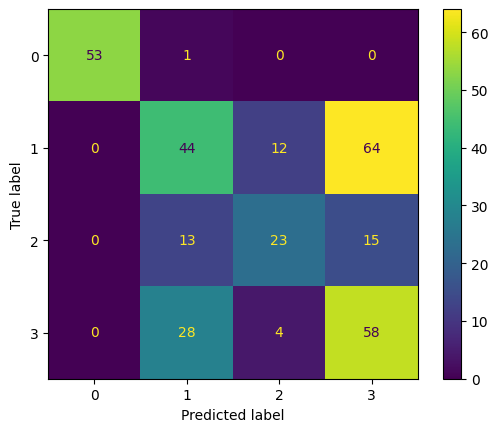

Accuracy on test dataset :  0.5650793650793651


In [78]:
def make_predictions(model,dataset_type):
    y_pred = model.predict(X[dataset_type])
    cm = confusion_matrix(y[dataset_type],y_pred)
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp_cm.plot()
    plt.show()

    correct_predictions = cm.diagonal().sum()
    total_samples = cm.sum()
    accuracy = correct_predictions / total_samples
    print(f"Accuracy on {dataset_type} dataset : ", accuracy)
    
make_predictions(model,'valid')
make_predictions(model,'test')

In [81]:
dump(model, 'C:/Users/galse/DS50/models/XGBoost.joblib')

['C:/Users/galse/DS50/models/XGBoost.joblib']